In [40]:
import re
import string
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, ComplementNB

from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
)

import joblib

pd.set_option("display.max_colwidth", 120)
pd.set_option("display.max_columns", 50)
sns.set_theme()
plt.rcParams["figure.figsize"] = (10, 5)


In [41]:
df_fake = pd.read_csv("Fake.csv")
df_true = pd.read_csv("True.csv")

df_fake["label"] = 0  # fake
df_true["label"] = 1  # real

df = pd.concat([df_fake, df_true], ignore_index=True)

print("Shape gabungan:", df.shape)
df.head()


Shape gabungan: (44898, 5)


,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing,"Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout...",News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian Collusion Investigation,"House Intelligence Committee Chairman Devin Nunes is going to have a bad day. He s been under the assumption, like m...",News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke For Threatening To Poke People ‘In The Eye’,"On Friday, it was revealed that former Milwaukee Sheriff David Clarke, who was being considered for Homeland Securit...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name Coded Into His Website (IMAGES),"On Christmas day, Donald Trump announced that he would be back to work the following day, but he is golfing for th...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump During His Christmas Speech,Pope Francis used his annual Christmas Day message to rebuke Donald Trump without even mentioning his name. The Pope...,News,"December 25, 2017",0


In [42]:
df.info()

print("\nMissing values:\n", df.isnull().sum())

print("\nDuplikat:", df.duplicated().sum())

print("\nDistribusi label:")
print(df["label"].value_counts())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   label    44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.7+ MB

Missing values:
 title      0
text       0
subject    0
date       0
label      0
dtype: int64

Duplikat: 209

Distribusi label:
label
0    23481
1    21417
Name: count, dtype: int64


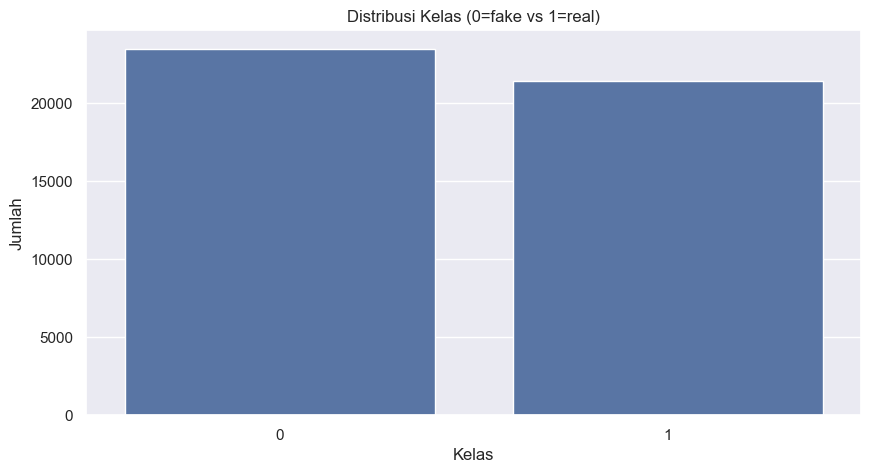

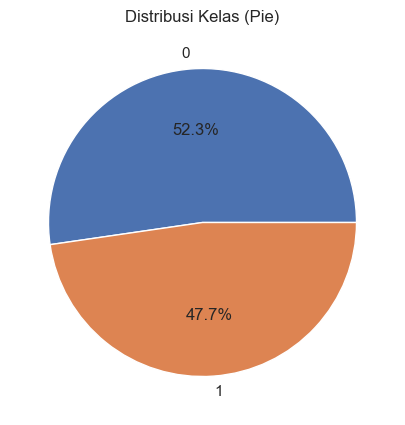

In [43]:
vc = df["label"].value_counts().sort_index()

plt.figure()
sns.barplot(x=vc.index.astype(str), y=vc.values)
plt.title("Distribusi Kelas (0=fake vs 1=real)")
plt.xlabel("Kelas")
plt.ylabel("Jumlah")
plt.show()

plt.figure()
plt.pie(vc.values, labels=[str(i) for i in vc.index], autopct="%1.1f%%")
plt.title("Distribusi Kelas (Pie)")
plt.show()


In [44]:
# isi missing jadi kosong
for c in ["title", "text"]:
    if c in df.columns:
        df[c] = df[c].fillna("")
    else:
        print("WARNING: kolom", c, "tidak ada!")

df["text_all"] = (df["title"].astype(str) + " " + df["text"].astype(str)).str.strip()

df["len_words"] = df["text_all"].apply(lambda x: len(str(x).split()))
df["len_chars"] = df["text_all"].apply(lambda x: len(str(x)))

df[["title", "text", "text_all", "label", "len_words"]].head(3)


,title,text,text_all,label,len_words
0,Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing,"Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout...",Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing Donald Trump just couldn t wish all A...,0,507
1,Drunk Bragging Trump Staffer Started Russian Collusion Investigation,"House Intelligence Committee Chairman Devin Nunes is going to have a bad day. He s been under the assumption, like m...",Drunk Bragging Trump Staffer Started Russian Collusion Investigation House Intelligence Committee Chairman Devin Nun...,0,313
2,Sheriff David Clarke Becomes An Internet Joke For Threatening To Poke People ‘In The Eye’,"On Friday, it was revealed that former Milwaukee Sheriff David Clarke, who was being considered for Homeland Securit...","Sheriff David Clarke Becomes An Internet Joke For Threatening To Poke People ‘In The Eye’ On Friday, it was revealed...",0,595


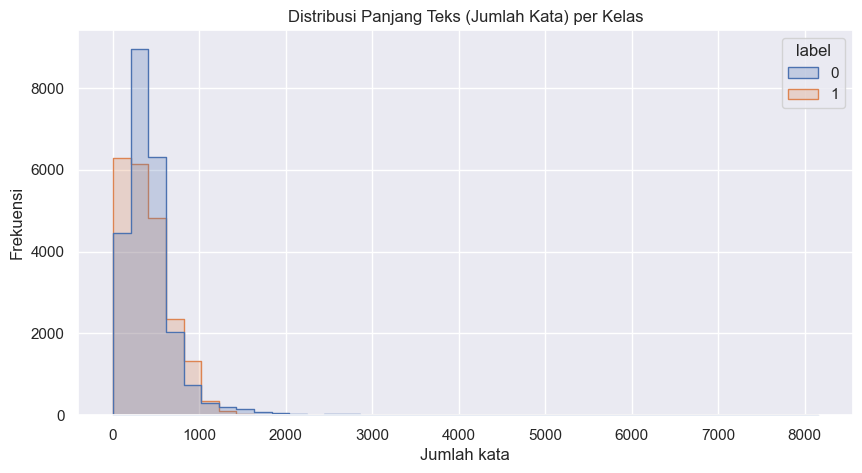

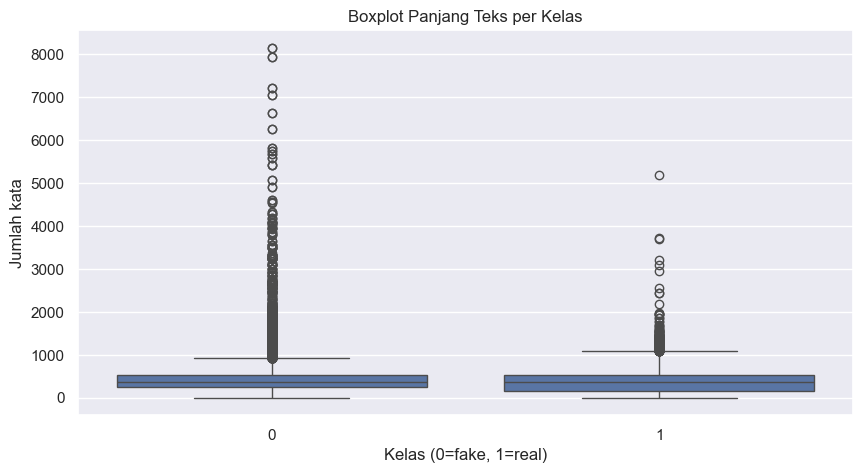

In [45]:
plt.figure()
sns.histplot(data=df, x="len_words", hue="label", bins=40, element="step")
plt.title("Distribusi Panjang Teks (Jumlah Kata) per Kelas")
plt.xlabel("Jumlah kata")
plt.ylabel("Frekuensi")
plt.show()

plt.figure()
sns.boxplot(data=df, x="label", y="len_words")
plt.title("Boxplot Panjang Teks per Kelas")
plt.xlabel("Kelas (0=fake, 1=real)")
plt.ylabel("Jumlah kata")
plt.show()


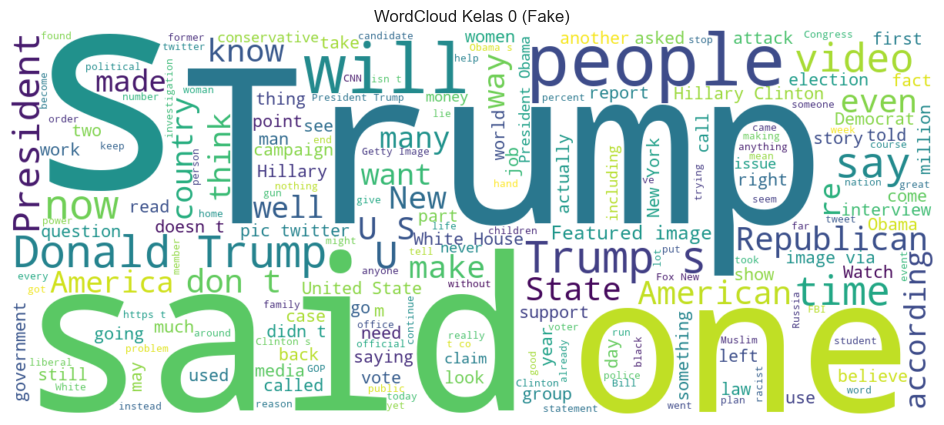

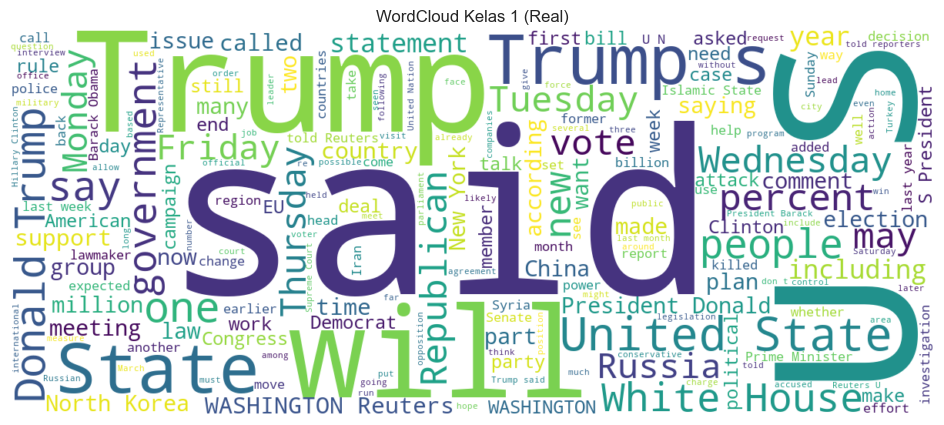

In [46]:
def show_wc(text, title):
    wc = WordCloud(width=1200, height=500, background_color="white").generate(text)
    plt.figure(figsize=(12, 5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)
    plt.show()

# hati-hati kalau teks terlalu besar → ambil sample untuk wordcloud
fake_text = " ".join(df.loc[df["label"] == 0, "text_all"].sample(n=min(5000, (df["label"]==0).sum()), random_state=42).astype(str))
real_text = " ".join(df.loc[df["label"] == 1, "text_all"].sample(n=min(5000, (df["label"]==1).sum()), random_state=42).astype(str))

show_wc(fake_text, "WordCloud Kelas 0 (Fake)")
show_wc(real_text, "WordCloud Kelas 1 (Real)")


In [47]:
def clean_text_light(s: str) -> str:
    s = str(s).lower()
    s = re.sub(r"http\S+|www\.\S+", " ", s)   # hapus url
    s = re.sub(r"\s+", " ", s).strip()       # rapikan spasi
    return s

df["text_clean"] = df["text_all"].apply(clean_text_light)

df[["text_all", "text_clean", "label"]].head(3)


,text_all,text_clean,label
0,Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing Donald Trump just couldn t wish all A...,donald trump sends out embarrassing new year’s eve message; this is disturbing donald trump just couldn t wish all a...,0
1,Drunk Bragging Trump Staffer Started Russian Collusion Investigation House Intelligence Committee Chairman Devin Nun...,drunk bragging trump staffer started russian collusion investigation house intelligence committee chairman devin nun...,0
2,"Sheriff David Clarke Becomes An Internet Joke For Threatening To Poke People ‘In The Eye’ On Friday, it was revealed...","sheriff david clarke becomes an internet joke for threatening to poke people ‘in the eye’ on friday, it was revealed...",0


In [48]:
X = df["text_clean"].values
y = df["label"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train:", len(X_train), "Test:", len(X_test))
print("Distribusi train:", np.bincount(y_train))
print("Distribusi test :", np.bincount(y_test))


Train: 35918 Test: 8980
Distribusi train: [18785 17133]
Distribusi test : [4696 4284]


Accuracy MNB: 0.9552338530066815
Confusion Matrix:
 [[4501  195]
 [ 207 4077]]

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96      4696
           1       0.95      0.95      0.95      4284

    accuracy                           0.96      8980
   macro avg       0.96      0.96      0.96      8980
weighted avg       0.96      0.96      0.96      8980



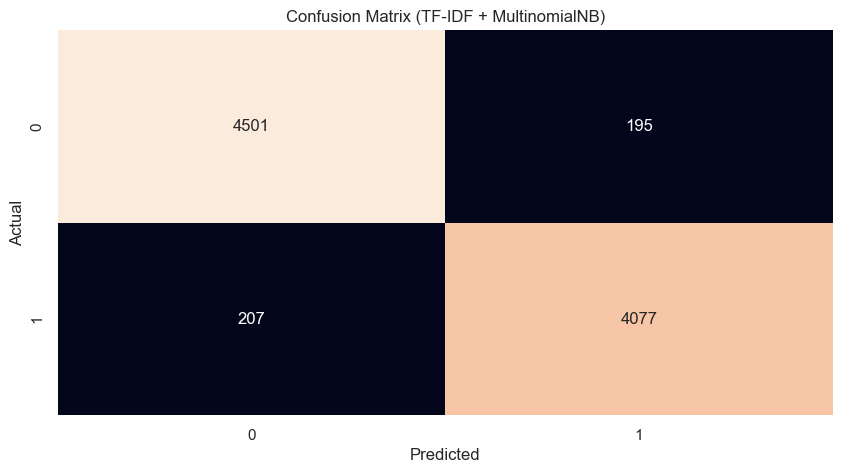

In [49]:
pipe_mnb = Pipeline([
    ("tfidf", TfidfVectorizer(
        stop_words="english",
        ngram_range=(1,2),
        max_features=60000,
        min_df=2,
        max_df=0.95
    )),
    ("nb", MultinomialNB(alpha=1.0))
])

pipe_mnb.fit(X_train, y_train)
pred_mnb = pipe_mnb.predict(X_test)
proba_mnb = pipe_mnb.predict_proba(X_test)[:, 1]

acc_mnb = accuracy_score(y_test, pred_mnb)
cm_mnb = confusion_matrix(y_test, pred_mnb)

print("Accuracy MNB:", acc_mnb)
print("Confusion Matrix:\n", cm_mnb)
print("\nClassification Report:\n", classification_report(y_test, pred_mnb))

plt.figure()
sns.heatmap(cm_mnb, annot=True, fmt="d", cbar=False)
plt.title("Confusion Matrix (TF-IDF + MultinomialNB)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


Accuracy CNB: 0.9579064587973274
Confusion Matrix:
 [[4503  193]
 [ 185 4099]]

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96      4696
           1       0.96      0.96      0.96      4284

    accuracy                           0.96      8980
   macro avg       0.96      0.96      0.96      8980
weighted avg       0.96      0.96      0.96      8980



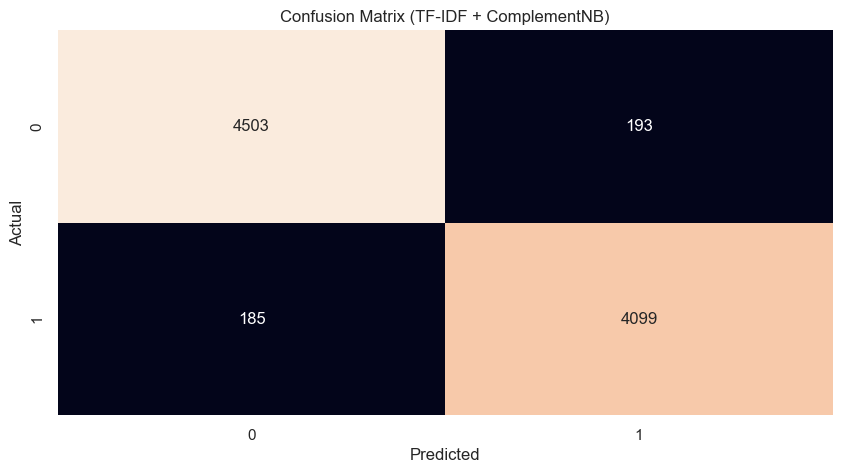

In [50]:
pipe_cnb = Pipeline([
    ("tfidf", TfidfVectorizer(
        stop_words="english",
        ngram_range=(1,2),
        max_features=60000,
        min_df=2,
        max_df=0.95
    )),
    ("nb", ComplementNB(alpha=0.5))
])

pipe_cnb.fit(X_train, y_train)
pred_cnb = pipe_cnb.predict(X_test)
proba_cnb = pipe_cnb.predict_proba(X_test)[:, 1]

acc_cnb = accuracy_score(y_test, pred_cnb)
cm_cnb = confusion_matrix(y_test, pred_cnb)

print("Accuracy CNB:", acc_cnb)
print("Confusion Matrix:\n", cm_cnb)
print("\nClassification Report:\n", classification_report(y_test, pred_cnb))

plt.figure()
sns.heatmap(cm_cnb, annot=True, fmt="d", cbar=False)
plt.title("Confusion Matrix (TF-IDF + ComplementNB)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


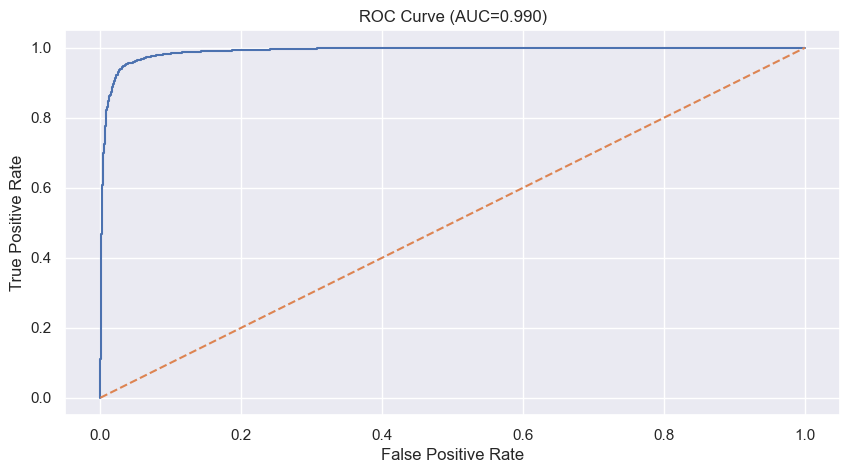

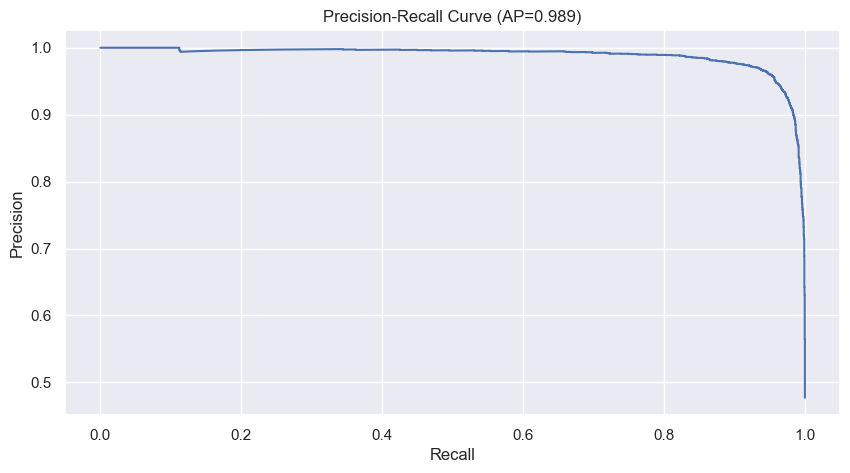

In [51]:
# pakai model terbaik sementara (pilih yang acc lebih tinggi)
best_pipe = pipe_cnb if acc_cnb >= acc_mnb else pipe_mnb
best_proba = proba_cnb if acc_cnb >= acc_mnb else proba_mnb
best_pred  = pred_cnb if acc_cnb >= acc_mnb else pred_mnb

auc = roc_auc_score(y_test, best_proba)
fpr, tpr, _ = roc_curve(y_test, best_proba)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1],"--")
plt.title(f"ROC Curve (AUC={auc:.3f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

prec, rec, _ = precision_recall_curve(y_test, best_proba)
ap = average_precision_score(y_test, best_proba)

plt.figure()
plt.plot(rec, prec)
plt.title(f"Precision-Recall Curve (AP={ap:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()


In [52]:
proba_all = best_pipe.predict_proba(X_test)
pred_all = best_pipe.predict(X_test)

mis_idx = np.where(pred_all != y_test)[0]
idx = mis_idx[0] if len(mis_idx) > 0 else np.random.randint(0, len(y_test))

sample_text = X_test[idx]
true_label = int(y_test[idx])
pred_label = int(pred_all[idx])
p0, p1 = proba_all[idx]

print("=== SAMPLE UNTUK predict_proba ===")
print("True label:", true_label, "(0=fake,1=real)")
print("Pred label:", pred_label)
print("P(0), P(1):", [float(p0), float(p1)])
print("Confidence:", float(max(p0, p1)))
print("\nCuplikan teks:\n", sample_text[:600], "...")


=== SAMPLE UNTUK predict_proba ===
True label: 1 (0=fake,1=real)
Pred label: 0
P(0), P(1): [0.7474662544031148, 0.25253374559687214]
Confidence: 0.7474662544031148

Cuplikan teks:
 newspapers aim to ride 'trump bump' to reach readers, advertisers new york (reuters) - the trump administration’s combative view of traditional news media as the “opposition party” and “fake news” is turning out to be the best hope in 2017 for newspapers struggling to attract more digital readers and advertisers. the new york times (nyt.n), the financial times, the wall street journal and gannett co are building on the online readership they gained during the 2016 presidential election by marketing unbiased reporting as a sales strategy. the risk, however, is whether those new readers will att ...


In [53]:
dummy_fake = """
Breaking: miracle cure works instantly for everyone! Share now before it gets deleted!
Secret government cover-up revealed. Doctors hate this trick!
"""

dummy_real = """
According to the official report released after a formal review, the agency published the methodology,
data sources, and a transcript of the public press conference.
"""

dummy_texts = [clean_text_light(dummy_fake), clean_text_light(dummy_real)]
dummy_pred = best_pipe.predict(dummy_texts)
dummy_proba = best_pipe.predict_proba(dummy_texts)

for i in range(2):
    print(f"\n=== Dummy {i+1} ===")
    print("Pred class:", int(dummy_pred[i]), "(0=fake,1=real)")
    print("Proba [P(0), P(1)]:", [float(dummy_proba[i][0]), float(dummy_proba[i][1])])
    print("Confidence:", float(np.max(dummy_proba[i])))
    print("Text:", dummy_texts[i])



=== Dummy 1 ===
Pred class: 0 (0=fake,1=real)
Proba [P(0), P(1)]: [0.984184652751256, 0.01581534724874304]
Confidence: 0.984184652751256
Text: breaking: miracle cure works instantly for everyone! share now before it gets deleted! secret government cover-up revealed. doctors hate this trick!

=== Dummy 2 ===
Pred class: 1 (0=fake,1=real)
Proba [P(0), P(1)]: [0.3793223188762066, 0.6206776811237966]
Confidence: 0.6206776811237966
Text: according to the official report released after a formal review, the agency published the methodology, data sources, and a transcript of the public press conference.


In [54]:
alphas = [0.05, 0.1, 0.3, 0.5, 1.0, 2.0]
results = []

for a in alphas:
    pipe = Pipeline([
        ("tfidf", TfidfVectorizer(
            stop_words="english",
            ngram_range=(1,2),
            max_features=80000,
            min_df=2,
            max_df=0.95
        )),
        ("nb", ComplementNB(alpha=a))
    ])
    pipe.fit(X_train, y_train)
    pred = pipe.predict(X_test)
    acc = accuracy_score(y_test, pred)
    results.append((a, acc))

res_df = pd.DataFrame(results, columns=["alpha", "accuracy"]).sort_values("accuracy", ascending=False)
res_df


,alpha,accuracy
0,0.05,0.962249
1,0.10,0.961693
2,0.30,0.959465
3,0.50,0.957350
4,1.00,0.954788
5,2.00,0.952673


Best alpha: 0.05
FINAL Accuracy: 0.9622494432071269
FINAL Confusion Matrix:
 [[4532  164]
 [ 175 4109]]

FINAL Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.97      0.96      4696
           1       0.96      0.96      0.96      4284

    accuracy                           0.96      8980
   macro avg       0.96      0.96      0.96      8980
weighted avg       0.96      0.96      0.96      8980



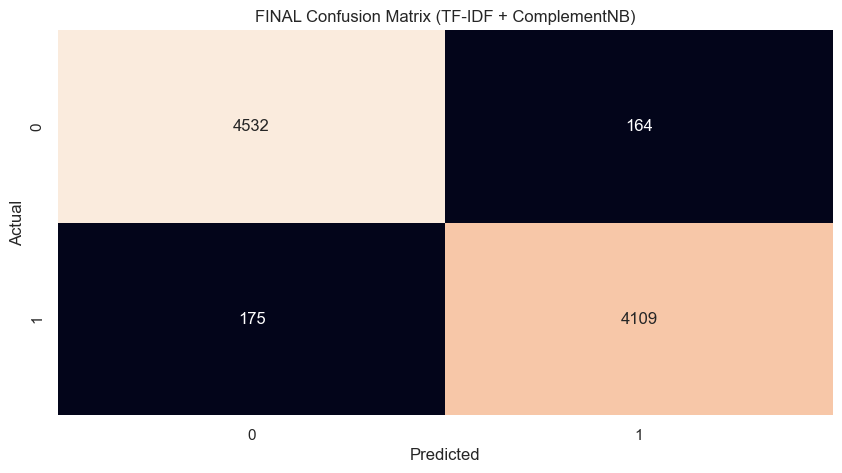

Saved: fake_real_news_nb_pipeline.joblib


In [55]:
best_alpha = float(res_df.iloc[0]["alpha"])
print("Best alpha:", best_alpha)

final_model = Pipeline([
    ("tfidf", TfidfVectorizer(
        stop_words="english",
        ngram_range=(1,2),
        max_features=80000,
        min_df=2,
        max_df=0.95
    )),
    ("nb", ComplementNB(alpha=best_alpha))
])

final_model.fit(X_train, y_train)
final_pred = final_model.predict(X_test)
final_proba = final_model.predict_proba(X_test)[:, 1]

final_acc = accuracy_score(y_test, final_pred)
final_cm = confusion_matrix(y_test, final_pred)

print("FINAL Accuracy:", final_acc)
print("FINAL Confusion Matrix:\n", final_cm)
print("\nFINAL Classification Report:\n", classification_report(y_test, final_pred))

plt.figure()
sns.heatmap(final_cm, annot=True, fmt="d", cbar=False)
plt.title("FINAL Confusion Matrix (TF-IDF + ComplementNB)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# simpan pipeline (sudah termasuk vectorizer)
joblib.dump(final_model, "fake_real_news_nb_pipeline.joblib")
print("Saved: fake_real_news_nb_pipeline.joblib")


In [56]:
loaded = joblib.load("fake_real_news_nb_pipeline.joblib")

test_text = "Breaking: You won't believe this shocking secret the media hides from you!"
pred = loaded.predict([test_text])[0]
proba = loaded.predict_proba([test_text])[0]

print("Pred:", int(pred), "(0=fake,1=real)")
print("Proba:", [float(proba[0]), float(proba[1])])


Pred: 0 (0=fake,1=real)
Proba: [0.9973343262672524, 0.0026656737327466853]
